Successfully generated 2185 hourly data points for load profile.

Data split: Training on 2017 hours, Testing on 168 hours.

--- SARIMA Model ---
Fitting SARIMA model with non-seasonal order (1, 1, 1) and seasonal order (1, 1, 0, 24)...
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2017
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 24)   Log Likelihood               -5745.508
Date:                             Tue, 03 Jun 2025   AIC                          11499.016
Time:                                     10:30:44   BIC                          11521.353
Sample:                                 03-01-2025   HQIC                         11507.224
                                      - 05-24-2025                                         
Covariance Type:                               opg                                         
                 coef    st

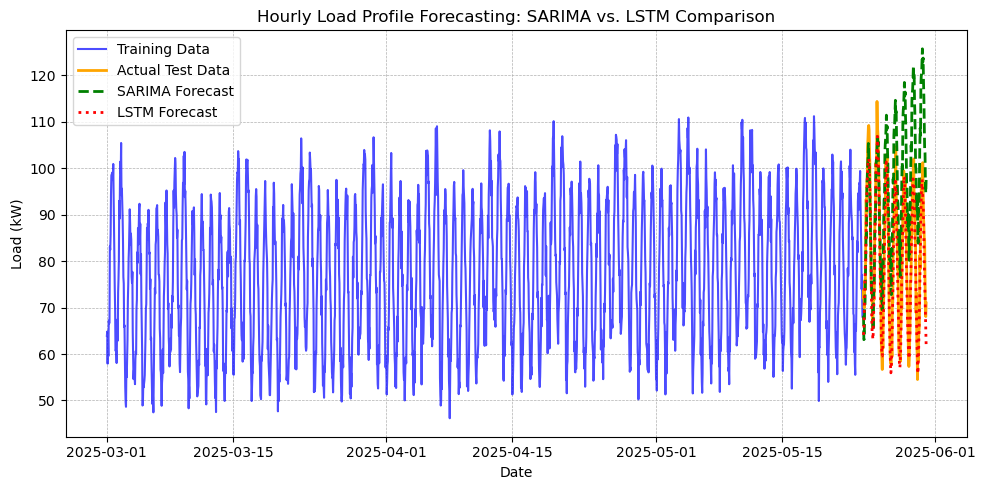

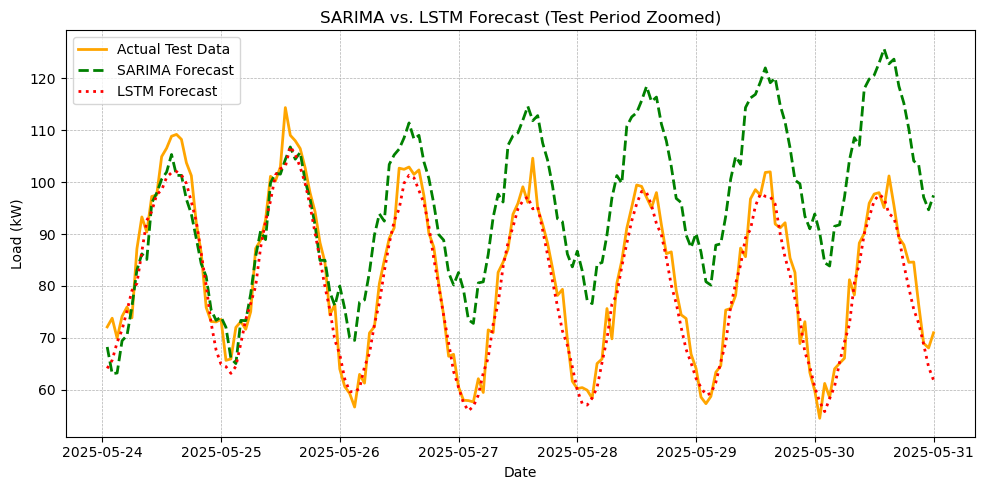


--- Summary of Performance ---
SARIMA: RMSE = 17.49, MAE = 14.96
LSTM:   RMSE = 3.97, MAE = 3.13


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

# Suppress harmless warnings
warnings.filterwarnings("ignore")

# --- 1. Generate Synthetic Hourly Load Profile Data ---
start_date = '2025-03-01'
end_date = '2025-05-31' # 3 months of hourly data
freq = 'H' # Hourly frequency

dates = pd.date_range(start=start_date, end=end_date, freq=freq)
n_points = len(dates)

base_load = 50
hour_of_day = dates.hour.to_numpy()
daily_pattern = (np.sin((hour_of_day - 8) * np.pi / 12) + 1) * 20

day_of_week = dates.dayofweek.to_numpy()
weekly_pattern = np.where(day_of_week < 5, 0, 10)

trend = np.linspace(0, 10, n_points)
noise = np.random.normal(0, 3, n_points)

load = np.array(base_load + daily_pattern + weekly_pattern + trend + noise)
load[load < 0] = 0

load_profile = pd.Series(load, index=dates)

print(f"Successfully generated {len(load_profile)} hourly data points for load profile.")

# --- 2. Visualize the Synthetic Data (Optional, already shown in previous steps) ---
# plt.figure(figsize=(15, 6))
# plt.plot(load_profile['2023-01-01':'2023-01-07'], label='First Week Load Profile')
# plt.title('Synthetic Hourly Load Profile - First Week Example')
# plt.xlabel('Date')
# plt.ylabel('Load (kW)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# --- 3. Prepare Data for Modeling (SARIMA & LSTM) ---
# Split the data into training and testing sets
test_period_hours = 7 * 24 # Use the last 7 days for testing
train_size = len(load_profile) - test_period_hours
train_data = load_profile[:train_size]
test_data = load_profile[train_size:]

print(f"\nData split: Training on {len(train_data)} hours, Testing on {len(test_data)} hours.")

# --- 4. SARIMA Model Training and Forecasting ---
print("\n--- SARIMA Model ---")
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 24) # Daily seasonality (24 hours)

print(f"Fitting SARIMA model with non-seasonal order {order} and seasonal order {seasonal_order}...")

sarima_model = SARIMAX(train_data,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())

# Generate SARIMA forecasts for the test period
sarima_predictions = sarima_model_fit.predict(start=len(train_data), end=len(load_profile) - 1, dynamic=False)
sarima_predictions.index = test_data.index

# Evaluate SARIMA
mse_sarima = mean_squared_error(test_data, sarima_predictions)
rmse_sarima = sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test_data, sarima_predictions)
print(f'SARIMA MSE: {mse_sarima:.2f}')
print(f'SARIMA RMSE: {rmse_sarima:.2f}')
print(f'SARIMA MAE: {mae_sarima:.2f}')

# --- 5. LSTM Model Training and Forecasting ---
print("\n--- LSTM Model ---")

# Scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_load = scaler.fit_transform(load_profile.values.reshape(-1, 1))

# Split scaled data
scaled_train_data = scaled_load[:train_size]
scaled_test_data = scaled_load[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        # Find the end of the prediction
        out_end_ix = end_ix + n_steps_out
        # Gather input and output parts of the pattern
        seq_x = data[i:end_ix]
        seq_y = data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in = 24 # Use past 24 hours to predict
n_steps_out = 1 # Predict 1 hour ahead

# Prepare training data for LSTM
X_train_lstm, y_train_lstm = create_sequences(scaled_train_data, n_steps_in, n_steps_out)
# LSTM input shape: (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
y_train_lstm = y_train_lstm.reshape(y_train_lstm.shape[0], y_train_lstm.shape[1])

print(f"LSTM training input shape: {X_train_lstm.shape}")
print(f"LSTM training output shape: {y_train_lstm.shape}")

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, 1)))
lstm_model.add(Dense(n_steps_out))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
print("Training LSTM model...")
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)
print("LSTM model trained.")

# Generate LSTM forecasts for the test period (one step at a time)
lstm_predictions_scaled = []
# For LSTM prediction, we need to feed it sequences from the end of the training data
# and then append each new prediction to the sequence for the next prediction.
# This simulates a rolling forecast.
current_batch = scaled_train_data[-n_steps_in:].reshape(1, n_steps_in, 1)

for i in range(len(test_data)):
    # Get the prediction for the next step
    predicted_val = lstm_model.predict(current_batch, verbose=0)[0]
    lstm_predictions_scaled.append(predicted_val[0])

    # Update the input batch for the next prediction
    # If using actual values for comparison (similar to dynamic=False in SARIMA predict)
    # This approach uses actual test data point to create the next input sequence
    next_actual_scaled_val = scaled_test_data[i].reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_actual_scaled_val, axis=1)

# Inverse transform the predictions to original scale
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions_scaled).reshape(-1, 1))
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index)
lstm_predictions[lstm_predictions < 0] = 0 # Ensure no negative predictions

# Evaluate LSTM
mse_lstm = mean_squared_error(test_data, lstm_predictions)
rmse_lstm = sqrt(mse_lstm)
mae_lstm = mean_absolute_error(test_data, lstm_predictions)
print(f'LSTM MSE: {mse_lstm:.2f}')
print(f'LSTM RMSE: {rmse_lstm:.2f}')
print(f'LSTM MAE: {mae_lstm:.2f}')

# --- 6. Comparative Visualization of Forecasts ---

plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data, label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange', linewidth=2)
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions.index, lstm_predictions, label='LSTM Forecast', color='red', linestyle=':', linewidth=2)

plt.title('Hourly Load Profile Forecasting: SARIMA vs. LSTM Comparison')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Zoom in on the forecast period for better visual comparison
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange', linewidth=2)
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions.index, lstm_predictions, label='LSTM Forecast', color='red', linestyle=':', linewidth=2)
plt.title('SARIMA vs. LSTM Forecast (Test Period Zoomed)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance ---")
print(f"SARIMA: RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM:   RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")

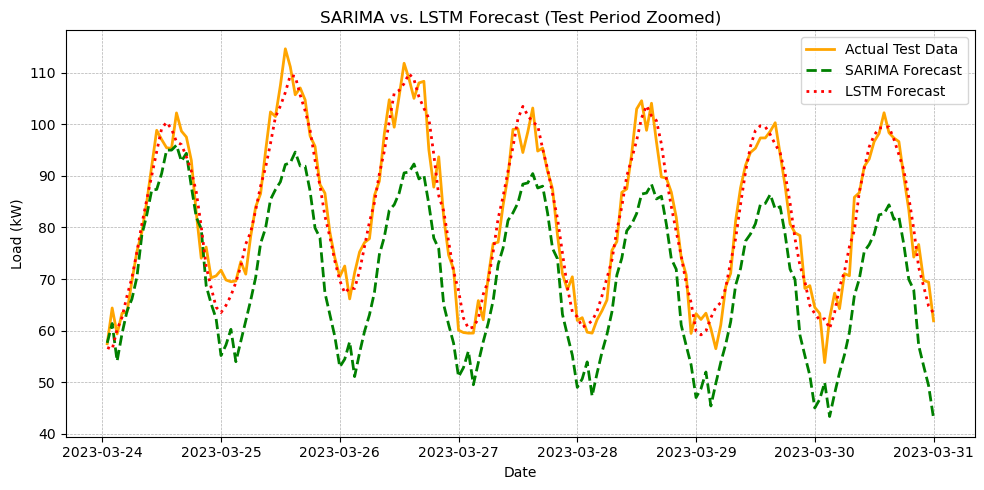


--- Summary of Performance ---
SARIMA: RMSE = 13.11, MAE = 12.01
LSTM:   RMSE = 3.56, MAE = 2.88


In [6]:
# Zoom in on the forecast period for better visual comparison
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange', linewidth=2)
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)
plt.plot(lstm_predictions.index, lstm_predictions, label='LSTM Forecast', color='red', linestyle=':', linewidth=2)
plt.title('SARIMA vs. LSTM Forecast (Test Period Zoomed)')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n--- Summary of Performance ---")
print(f"SARIMA: RMSE = {rmse_sarima:.2f}, MAE = {mae_sarima:.2f}")
print(f"LSTM:   RMSE = {rmse_lstm:.2f}, MAE = {mae_lstm:.2f}")